Вариант № 1, выполнил Евгений Амелин. 
Поток № 42 от 19.06.2023

In [21]:
import pandas as pd
%matplotlib inline
import seaborn as sns
from scipy import stats
from statistics import variance
from scipy.stats import levene
import pingouin as pg
from scipy.stats import chi2_contingency

sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize': (20, 7)}
       )


#### Задание 1
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention игроков (по дням от даты регистрации игрока). Данные лежат в папке shared и имеют следующую структуру:

problem1-reg_data.csv – данные о времени регистрации

problem1-auth_data.csv – данные о времени захода пользователей в игру

Функция должна быть написана на python. В ходе решения можно тестировать работу функции как на полном датасете, так и на части (сэмпле) данных.

In [22]:
# Загрузим данные
reg = pd.read_csv('problem1-reg_data.csv', sep=";")
auth = pd.read_csv('problem1-auth_data.csv', sep=";")

In [23]:
# Приведем столбцы reg_ts, auth_ts к понятному формату даты.
reg['reg_ts'] = pd.to_datetime(reg['reg_ts'], origin='unix', unit='s')
auth['auth_ts'] = pd.to_datetime(auth['auth_ts'], origin='unix', unit='s')

In [24]:
# Посмотрим на данные, их кол-во, типы, пропуски.
reg.head()

,reg_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,2000-01-13 22:27:27,3
3,2000-05-28 14:19:01,4
4,2000-09-16 11:21:53,5


In [25]:
reg.shape

(1000000, 2)

In [26]:
# Всего  1000000 регистраций пользователей, все Id уникальные.
reg.nunique()

reg_ts    1000000
uid       1000000
dtype: int64

In [27]:
auth.head()

,auth_ts,uid
0,1998-11-18 09:43:43,1
1,1999-07-22 22:38:09,2
2,1999-07-25 16:46:46,2
3,1999-07-31 03:50:15,2
4,1999-08-05 17:49:39,2


In [28]:
auth.shape

(9601013, 2)

In [29]:
# Пропусков в значениях нет, данные в корректном типе
reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 2 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   reg_ts  1000000 non-null  datetime64[ns]
 1   uid     1000000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 15.3 MB


In [30]:
auth.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9601013 entries, 0 to 9601012
Data columns (total 2 columns):
 #   Column   Dtype         
---  ------   -----         
 0   auth_ts  datetime64[ns]
 1   uid      int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 146.5 MB


In [31]:
# Кол-во уникальных пользователей совпадает. Если при мердже не появится лишних строк, значит все хорошо.
auth.nunique()

auth_ts    9180915
uid        1000000
dtype: int64

In [32]:
# Перед написанием функции проделаем все операции пошагово
# Объединим таблицы по Id
df = reg.merge(auth)

In [33]:
df.uid.nunique()

1000000

In [34]:
# Посмотрев на даты, заметим, что данные у нас за 20+лет.
df.reg_ts.min()

Timestamp('1998-11-18 09:43:43')

In [35]:
df.reg_ts.max()

Timestamp('2020-09-23 15:17:24')

In [36]:
df.auth_ts.max()

Timestamp('2020-09-23 15:17:24')

In [37]:
df.head()

,reg_ts,uid,auth_ts
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39


In [38]:
# Упростим дату регистрации до месяца
df['cohort'] = df.reg_ts.dt.to_period('M')

In [39]:
# Если посмотреть каждый год. 
# До 2005 года за исключением 1999, кол-во новых пользователей колеблется от 1 до 17. 
# Возможно в 1999 была попытка запустить проект, но не успешно(бета-тест по итогу которого было много негативных замечаний)
# И до 2005 велась видимо разработка с привличением возможно друзей(знакомых), для получения какой-то обратной связи об игре.
# Начиная с 2005, начинает появляться активность, не каждый месяц(возможно реклама, или раздача ключей на бесплатное бета тестирование)
df.groupby('cohort').agg({'reg_ts': 'count'})

,reg_ts
cohort,
1998-11,1
1999-07,1929
2000-01,1
2000-05,1
2000-09,1
...,...
2020-05,151939
2020-06,135940
2020-07,131604


In [40]:
# Посчитаем кол-во дней у каждого игрока с момента регистрации до последнего его захода в игру.
df['day'] = (df.auth_ts - df.reg_ts).dt.days

In [41]:
# Введем переменную Gamer, нужна будет для расчета удержания в процентах(100 деленное на кол-во уникальных игроков)
Gamer = 100 / df.uid.nunique()
Gamer

0.0001

In [42]:
# Посмотрим на удержание с первого дня.
# В последний день видим непонятно высокое значение,
# это потому что в расчете учитывались по несколько заходов в игру в день.
(df.day.value_counts().sort_index() * Gamer).head()

day
0    100.0000
1      4.0202
2      4.2991
3      4.9152
4      5.6070
Name: count, dtype: float64

In [43]:
(df.day.value_counts().sort_index() * Gamer).tail()

day
7715    0.0001
7719    0.0001
7720    0.0001
7726    0.0001
7728    0.0001
Name: count, dtype: float64

In [44]:
# Перебрав данные замечаем удержание фиксируется примерно на 55-56 дне и идет на спад без скачков.
# Поэтому будем считать удержанными тех игроков кто провел в игре 60 и более дней и приравняем их к 60 дню.
# Так же создам столбец с годом и месяцем регистрации пользователя.
# Уберем так же дупликаты, в день считаем только 1 заход в игру
dfdf = df
dfdf.loc[dfdf.day >= 60, 'day'] = 60
dfdf = dfdf.drop_duplicates(subset=['day', 'uid'])

dfdf

,reg_ts,uid,auth_ts,cohort,day
0,1998-11-18 09:43:43,1,1998-11-18 09:43:43,1998-11,0
1,1999-07-22 22:38:09,2,1999-07-22 22:38:09,1999-07,0
2,1999-07-22 22:38:09,2,1999-07-25 16:46:46,1999-07,2
3,1999-07-22 22:38:09,2,1999-07-31 03:50:15,1999-07,8
4,1999-07-22 22:38:09,2,1999-08-05 17:49:39,1999-07,13
...,...,...,...,...,...
9601008,2020-09-23 15:13:54,1110618,2020-09-23 15:13:54,2020-09,0
9601009,2020-09-23 15:14:46,1110619,2020-09-23 15:14:46,2020-09,0
9601010,2020-09-23 15:15:39,1110620,2020-09-23 15:15:39,2020-09,0
9601011,2020-09-23 15:16:31,1110621,2020-09-23 15:16:31,2020-09,0


In [45]:
# Т.к. все игроки записались с удержание 60+ дней теперь в 60 днях фигурируют, на графиках в будущем будет скачок,
# но будем это принимать к сведению.
dfdf.day.value_counts().sort_index() * Gamer

day
0     100.0000
1       4.0202
2       4.2991
3       4.9152
4       5.6070
        ...   
56      1.1494
57      1.1351
58      1.1336
59      1.1339
60      4.5337
Name: count, Length: 61, dtype: float64

In [46]:
# Запишем данные в отдельный датафрейм и построим график
dfsns = (dfdf.day.value_counts().sort_index() * Gamer).to_frame().reset_index()
dfsns

,day,count
0,0,100.0000
1,1,4.0202
2,2,4.2991
3,3,4.9152
4,4,5.6070
...,...,...
56,56,1.1494
57,57,1.1351
58,58,1.1336
59,59,1.1339


<Axes: xlabel='day', ylabel='count'>

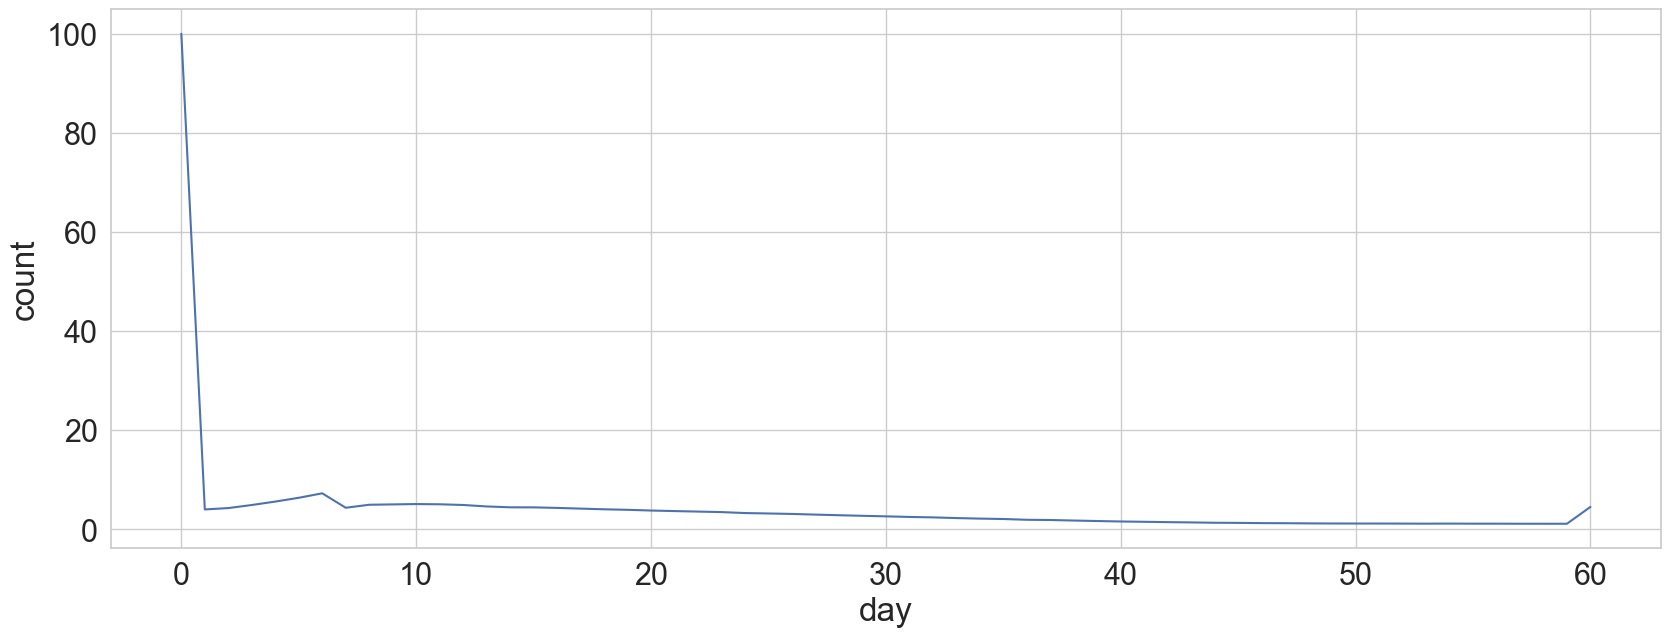

In [47]:
# Из-за того что в нулевой день у нас 100% удержание график плохо отражает скачки удержания между днями.
# Уберем 0 день, и так понятно что там 100% и крайний день так же отсечем.
sns.lineplot(dfsns, x='day', y='count')

<Axes: xlabel='day', ylabel='count'>

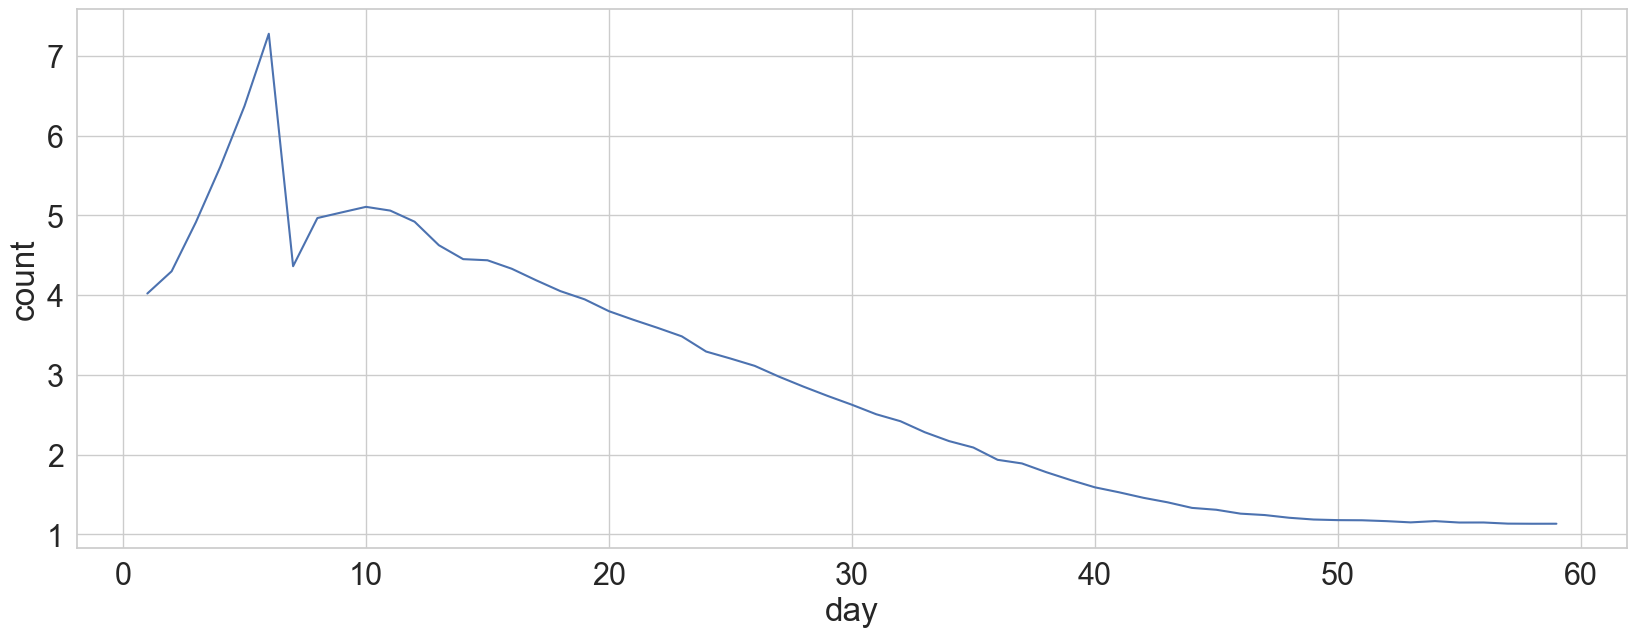

In [48]:
# Так нагляднее и видно, что игроки проявляют интерес и возвращаются в игру в первые 10-15 дней,
# а потом постепеннно теряют интерес.
sns.lineplot(dfsns.iloc[1:-1], x='day', y='count')

In [49]:
# Теперь все это перепишем в функцию
# Добавим возможность выбирать интервал за который мы хотим посмотреть наше удержание
def Retention(reg, auth, day_one, day_two):
    '''Принимает 2 датафрейма содержащие время регистрации и время захода в игру и айди пользователя
    и 2 строки с датами, началом и окончание периода за который мы хотим увидеть удержание.
    Возващает датафрейм с данными и график удержания за выбраный промежуток времени'''
    short_reg = reg[(reg['reg_ts'] >= day_one) & (reg['reg_ts'] <= day_two)]
    short_auth = auth[(auth['auth_ts'] >= day_one) & (auth['auth_ts'] <= day_two)]
    df = short_reg.merge(short_auth)
    Gamer = 100 / df.uid.nunique()
    df['day'] = (df.auth_ts - df.reg_ts).dt.days
    df.loc[df.day >= 60, 'day'] = 60
    dfdf = df.drop_duplicates(subset=['day', 'uid'])
    dfsns = (dfdf.day.value_counts().sort_index() * Gamer).to_frame().reset_index()
    Figura = sns.lineplot(dfsns.iloc[1:-1], x='day', y='count')
    Figura.set(xlabel='Кол-во дней', ylabel='Удержание (%)')
    return dfsns, Figura

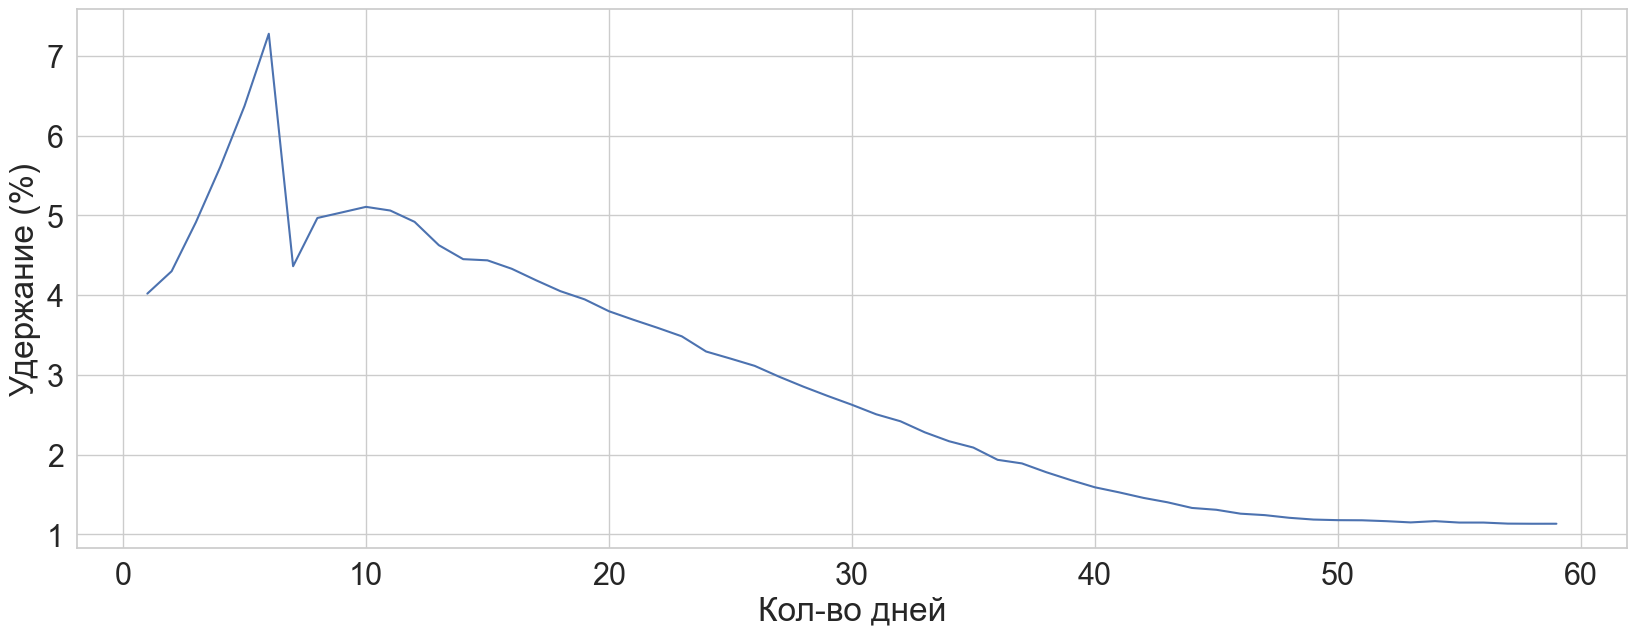

In [79]:
# Подставим мин и макс даты и сравним графики с выше полученным. Сходятся, функция работает корректно.
Figura = Retention(reg, auth, '1998-11-18', '2020-09-23')

In [80]:
dfsns

,day,count
0,0,100.0000
1,1,4.0202
2,2,4.2991
3,3,4.9152
4,4,5.6070
...,...,...
56,56,1.1494
57,57,1.1351
58,58,1.1336
59,59,1.1339


#### Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [52]:
# Загрузим таблицу:
# где:
# user_id -id Пользователя
# revenue - сумма которую потратил пользователь
# testgroup - к какой тестовой группе относится пользователь a или b
AB = pd.read_csv('Проект_1_Задание_2.csv', sep=";")

In [53]:
# Посмотрим на данные
AB.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [54]:
# Посмотрим на типы данных и кол-во пропусков
AB.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404770 entries, 0 to 404769
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   user_id    404770 non-null  int64 
 1   revenue    404770 non-null  int64 
 2   testgroup  404770 non-null  object
dtypes: int64(2), object(1)
memory usage: 9.3+ MB


In [55]:
AB.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [56]:
AB.user_id.nunique()

404770

In [57]:
# Средняя выручка на пользователя в каждой группе равна 25 y.e +-1 y.e, изучим детальнее дальше.
# (75% пользователей не совершали никаких операций)
AB.groupby('testgroup').describe()

user_id                                                         \
              count           mean            std  min       25%       50%   
testgroup                                                                    
a          202103.0  202555.909843  116802.329266  2.0  101502.5  202988.0   
b          202667.0  202215.564389  116891.926690  1.0  100855.5  201821.0   

                                revenue                                        \
                75%       max     count       mean         std  min  25%  50%   
testgroup                                                                       
a          303559.0  404769.0  202103.0  25.413720  920.768137  0.0  0.0  0.0   
b          303602.5  404770.0  202667.0  26.751287  287.324162  0.0  0.0  0.0   

                         
           75%      max  
testgroup                
a          0.0  37433.0  
b          0.0   4000.0

In [58]:
# Сравним пользователей в группах, которые приносили выручку.(это 0.9% пользователей от общего числа)
# В тестовой группе их меньше, но выше минимальная выручка и разброс не такой большой как в контрольной группе.
AB[AB.revenue != 0].groupby('testgroup').describe()

user_id                                                           \
            count           mean            std    min       25%       50%   
testgroup                                                                    
a          1928.0  200152.677905  116596.504905   73.0   99323.0  199854.5   
b          1805.0  205834.548476  116400.045485  161.0  106815.0  206651.0   

                               revenue                                    \
                 75%       max   count         mean          std     min   
testgroup                                                                  
a          299664.25  404768.0  1928.0  2663.998444  9049.039763   200.0   
b          304907.00  404526.0  1805.0  3003.658172   572.619709  2000.0   

                                            
              25%     50%     75%      max  
testgroup                                   
a           257.0   311.0   361.0  37433.0  
b          2513.0  3022.0  3478.0   4000.0

In [59]:
# Посмотрим на кол-во пользователей и сумму затрат в каждой группе
# и определим какая является тестовая, а какая контрольная.
# Из условия мы знаем что в контрольной группе 202103 пользователей, а в тестовой 202667, получаем:
# testgroup: a - контрольная группа, testgroup b - тестовая 
AB.groupby('testgroup').agg({'revenue': 'sum', 'user_id': 'count'})

,revenue,user_id
testgroup,,
a,5136189,202103
b,5421603,202667


In [60]:
# Определим 3 метрики для анализа нашего АБ теста.
# 1. ARPU
# 2. ARPPU
# 3. Конверсия в покупку

In [61]:
# 1. ARPU достаточно низкий в обеих группах и на мой взгляд и не имеет особых различий
AB.groupby('testgroup').agg({'revenue': 'mean'})

,revenue
testgroup,
a,25.413720
b,26.751287


In [62]:
# Проведем тест на нормальность групп a и b.
pg.normality(AB[AB.testgroup == 'a'].revenue, method="normaltest")

,W,pval,normal
revenue,585152.731273,0.0,False


In [63]:
pg.normality(AB[AB.testgroup == 'b'].revenue, method="normaltest")

,W,pval,normal
revenue,326622.395409,0.0,False


In [64]:
# Посчитаем дисперсию
variance(AB[AB.testgroup == 'a'].revenue), variance(AB[AB.testgroup == 'b'].revenue)

(847813.9618075917, 82555.17387895365)

In [65]:
# Т.к. данные распределены не нормально используем Levene's Test на сравнение однородности дисперсий
pg.homoscedasticity(data=AB, dv='revenue', group='testgroup') 

,W,pval,equal_var
levene,0.389629,0.532495,True


In [66]:
# У нас не нормальное распределние в обеих группах, но дисперсии однородны,
# поэтому для сравнения ARPU в группах используем Т-тест Стьюдента для проверки равенства средних значений в двух выборках.
# H0 - у пользователей из групп a и b ARPU не различаются. 
# H1 у пользователей из групп a и b в ARPU различаются.
# pvalue 0.05
stats.ttest_ind(AB[AB.testgroup == 'a'].revenue, AB[AB.testgroup == 'b'].revenue, equal_var=False)
# Т.к. pvalue=0.5329647014130866 > 0.05 принимаем H0. 
# У нас не достаточно доказательств сказать, что у пользователей из групп a и b ARPU различаются.

TtestResult(statistic=-0.6234876562792212, pvalue=0.5329647014130866, df=240991.13078245192)

In [67]:
# 2. ARPPU
AB.groupby('testgroup').agg({'revenue': 'sum'})

,revenue
testgroup,
a,5136189
b,5421603


In [68]:
# Посмотим на дисперсию.
variance(AB.loc[(AB.testgroup == 'a') & (AB.revenue != 0)].revenue), \
variance(AB.loc[(AB.testgroup == 'b') & (AB.revenue != 0)].revenue)

(81885120.63985227, 327893.33153656696)

In [69]:
# Посмотрев на дисперсию, видим что она не однородная. Поэтому в данном случае лучше подойдет Welch’s t-test.
statistic, p_value = levene(AB.loc[(AB.testgroup == 'a') & (AB.revenue != 0)].revenue,
                            AB.loc[(AB.testgroup == 'b') & (AB.revenue != 0)].revenue)
print("Statistic:", statistic)
print("p-value:", p_value)
if p_value > 0.05:
    print("Дисперсии не отличаются статистически значимо")
else:
    print("Дисперсии отличаются статистически значимо")

Statistic: 80.85567421779912
p-value: 3.779689868667878e-19
Дисперсии отличаются статистически значимо


In [70]:
ABAB = AB[AB.revenue != 0]
ABAB

,user_id,revenue,testgroup
72,73,351,a
160,161,3797,b
341,342,290,a
377,378,3768,b
385,386,250,a
...,...,...,...
404315,404316,262,a
404525,404526,3120,b
404543,404544,369,a
404602,404603,251,a


<Axes: xlabel='revenue', ylabel='Count'>

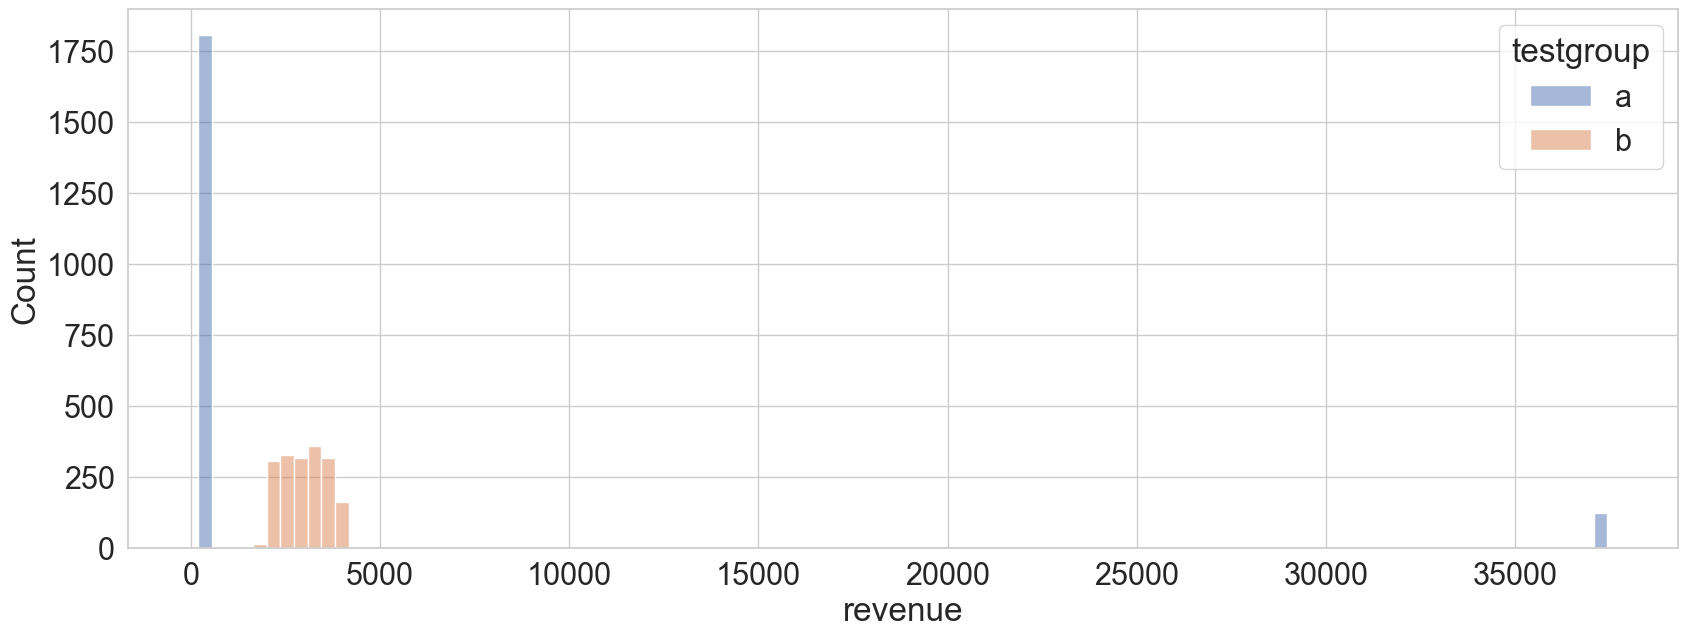

In [71]:
# Наглядно посмотрим на группы а и b по выручке
# в группе a большая часть пользователей покупали акции за небольшу сумму и лишь небольшая часть свыше 35000.
# А в группе b выручка не так разбросана.
sns.histplot(ABAB[['testgroup', 'revenue']], x="revenue", hue="testgroup")

In [72]:
# Используем Welch’s t-test.
# H0 - у пользователей из групп a и b ARPPU не различаются. 
# H1 у пользователей из групп a и b в ARPPU различаются.
# pvalue 0.05
stats.ttest_ind(AB.loc[(AB.testgroup == 'a') & (AB.revenue != 0)].revenue,
                AB.loc[(AB.testgroup == 'b') & (AB.revenue != 0)].revenue, equal_var=False)
# Т.к. pvalue=0.10020780398916015 > 0.05 принимаем H0. 
# У нас не достаточно доказательств сказать, что у пользователей из групп a и b ARPPU различаются.

TtestResult(statistic=-1.644630266430084, pvalue=0.10020780398916015, df=1943.4815217434643)

In [73]:
# 3. Конверсия в покупку
# Посчитаем конверсию в покупку, для этого создадим столбец в котором будет указано совершал покупку или нет.
AB['Buy'] = (AB['revenue'] > 0).astype(int)
AB

,user_id,revenue,testgroup,Buy
0,1,0,b,0
1,2,0,a,0
2,3,0,a,0
3,4,0,b,0
4,5,0,b,0
...,...,...,...,...
404765,404766,0,a,0
404766,404767,0,b,0
404767,404768,231,a,1
404768,404769,0,a,0


In [74]:
conversionA = (AB[(AB.testgroup == 'a') & (AB.Buy == 1)].Buy.count() / AB[AB.testgroup == 'a'].Buy.count()) * 100
conversionA


0.9539690157988748

In [75]:
# Конверсии в покупку практически не различается в группах 0.95% в контрольной группе и 0.89% в тестовой.
conversionB = (AB[(AB.testgroup == 'b') & (AB.Buy == 1)].Buy.count() / AB[AB.testgroup == 'b'].Buy.count()) * 100
conversionB

0.8906235351586593

In [76]:
# Посчитаем дисперсию
variance(AB[AB.testgroup == 'a'].Buy), variance(AB[AB.testgroup == 'b'].Buy)

(0.009448731221736537, 0.008826957877445581)

In [77]:
# Посмотрев на дисперсию, видим что она не однородная.
statistic, p_value = levene(AB[AB.testgroup == 'a'].Buy, AB[AB.testgroup == 'b'].Buy)
print("Statistic:", statistic)
print("p-value:", p_value)
if p_value > 0.05:
    print("Дисперсии не отличаются статистически значимо")
else:
    print("Дисперсии отличаются статистически значимо")

Statistic: 4.443810968963101
p-value: 0.03502858727059322
Дисперсии отличаются статистически значимо


In [78]:
# Для определения связи бинарных переменных и проверки наличия статистически значимой связи между 
# тестовой и контрольной группами лучше всего подойдет тест Хи-квадрат.
# H0 - у пользователей из групп a и b конверсии в покупку не различаются. 
# H1 - у пользователей из групп a и b конверсии в покупку различаются.
# pvalue 0.05
stat, p, dof, expected = chi2_contingency(pd.crosstab(AB.Buy, AB.testgroup))
stat, p
# Т.к. pvalue=0.03647561892312613 < 0.05 принимаем H1.
# У нас не достаточно доказательств сказать, что у пользователей из групп a и b конверсии в покупку не различаются.

(4.374729521260405, 0.03647561892312613)

#### Вывод
По итогу анализа метрик мы получили:
1. Различия ARPU в тестовой и контрольной группах статистически не значимы
2. Различия ARPPU в тестовой и контрольной группах статистически не значимы
3. Различия конверсий в покупку в тестовой и контрольной группах статистически значимы

Так же видно, что группам судя по всему давались наборы акций с разным разбросом в стоимости. \
В тестовой группе был узкий ценовой диапозон, с намного большей минимальной стоимостью чем в контрольной группе. \
Видимо больший выбор акций в ценовом диапозоне показал конверсию выше в контрольной группе на ~7%, но при этом общая выручка оказалась меньше на 285 414y.e(~5,5%) и средний чек меньше на 1,34y.e(~5,3%). \
Повышение прибыли и среднего чека статистически не значима, поэтому основываясь на проведенных тестах различия групп не дают желаемого результата, для запуска тестового набора. \
И для нового АБ теста необходимо подумать как повысить конверсию в покупку. \
Потому что на данном этапе, если задача стояла в повышении конверсии, то она провалилась.


## Задание 3 
В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. \
В них игроки могут получить уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. \
Для получения награды требуется пройти ряд уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события? 

Для оценки проведеного события я бы предложил использовать:
1. Потраченное время. Учитывая что ивент ограничен по времени, для создания будущих ивентов и анализа текущего полезно будет замерять сколько игрок затратил времени на прохождение всех уровней.
2. Конверсия завершения ивента. Не совсем понятно участвуют все игроки или событие надо принять. Но в любом случае надо учитывать сколько из участующих в ивенте игроков дошли до конца и получили награду.
3. На каком уровне игрок забрасывает ивент.
4. Затраченное время на каждый уровень. Для выявления багов или проблемных уровней надо наблюдать за средней проодимостью каждого уровня, чтобы выявлять в каких ситуациях игроки затрудняются пройти дальше. Так же если какие-то были пройдены слишком быстро, можно сделать посложнее в будущем или наоборот(зависит от цели ивента)
5. Если участие в ивенте надо подтверждать дополнительным действием, то можно отслеживать кол-во желающих получить награду в зависимости от самой награды(и при маленькой активности увеличивать в будущем кол-во бонусов)


Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. \
Изменится ли набор метрик оценки результата? Если да, то как?

В данном случае игрок может столкнутся с:
1. Прохождением одного и того же уровня несколько раз
2. Дополнительным стрессом при отбрасывании на несколько и более уровней включая до самого первого. 
С одной стороны делает награду более желанной и получение доставит больше удовольствия. Но с другой скорей всего меньше игроков закончит данный ивент(конечно зависит от сложности самого ивента)Так как не каждый захочет проходить один и тот же уровень по многу раз или просто может не хватить времени.

В данном случае можно добавить несколько метрик к выше перечисленным:
1. Сколько раз успешно проходился один и тот же уровень игроком.
2. Можно замерять время потраченное на каждый повторный уровень.

Экспериментировать можно как со сложностью, так и с наградами, все зависит от желаемого результата. Анализируя полученные данные подстраивать будущие ивенты под желаемые результаты. Если необходим дополнительный донат, то как раз можно экспериментировать с усложнением ивента и уровней и вводить за донат вещи или способности, которые упростят прохождение. Награду можно делать уникальной в таком случае, которую не получить другими способами. Если же важно удержать игроков или вернуть ушедших, то там уже свои нюансы.(может ивент будет презентовать новый патч, с продолжением игры и т.д.)

